utilized from optuna for hyper parameter optimization technic.

and enhance performance of lstm model via best params

In [ ]:
# Import Required Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import IsolationForest
import os
import optuna
import optuna.visualization as vis
import json
import sys
from torch.utils.tensorboard import SummaryWriter

In [ ]:
# Add the parent directory to the Python path
sys.path.append('../') 
from models.lstm_forecast_model import LSTMForecast
from models.timeseries_dataset_class import TimeSeriesDataset

# ✅ Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

In [ ]:

# SMAPE calculation
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 100 * np.mean(diff)

In [ ]:
# Evaluate model
def evaluate_model(model, dataloader, title, plot_name, writer=None, step=0):
    model.eval()
    all_preds, all_trues = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            pred = model(x).cpu().numpy()
            all_preds.append(pred)
            all_trues.append(y.numpy())
    predictions = np.concatenate(all_preds)
    truths = np.concatenate(all_trues)

    plt.figure(figsize=(10, 5))
    plt.plot(truths[:100], label="True")
    plt.plot(predictions[:100], label="Predicted")
    plt.legend()
    plt.title(title)
    plt.grid(True)
    os.makedirs("../../outputs/LSTM_Model", exist_ok=True)
    plot_path = f"../../outputs/LSTM_Model/{plot_name}"
    plt.savefig(plot_path)
    plt.show()
    print(f"✅ Plot saved to outputs/{plot_name}")

    mse = mean_squared_error(truths, predictions)
    mae = mean_absolute_error(truths, predictions)
    smape_val = smape(truths, predictions)
    print(f"📊 {title} Metrics:")
    print(f" - MSE   : {mse:.6f}")
    print(f" - MAE   : {mae:.6f}")
    print(f" - SMAPE : {smape_val:.2f}%")

    if writer:
        writer.add_scalar("Metrics/MSE", mse, step)
        writer.add_scalar("Metrics/MAE", mae, step)
        writer.add_scalar("Metrics/SMAPE", smape_val, step)

    return predictions, truths

In [ ]:
# Anomaly scoring based on residual thresholding
def anomaly_score(y_true, y_pred, threshold=3.0):

    # Ensure y_true and y_pred are 1D arrays with flattening or squeezing
    if y_true.ndim > 1:
        y_true = y_true.flatten()
    if y_pred.ndim > 1:
        y_pred = y_pred.flatten()

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape for anomaly detection.")

    residual = np.abs(y_true - y_pred)
    mean = np.mean(residual)
    std = np.std(residual)
    z_score = (residual - mean) / std
    anomalies = np.where(np.abs(z_score) > threshold)[0]


    plt.figure(figsize=(15, 5))
    plt.plot(y_true, label='True')
    plt.plot(y_pred, label='Predicted')
    plt.scatter(anomalies, y_true[anomalies], color='red', label='Anomalies')
    plt.title("Anomaly Detection Result via z-score")
    plt.legend()
    plt.grid(True)
    plt.savefig("../../outputs/LSTM_Model/anomaly_detection_visual_z_score.png")
    plt.show()
    print("✅ Anomaly plot saved to anomaly_detection_visual_z_score.png")

    # Automatic anomaly description
    for idx in anomalies[:5]:
        true_val = float(np.ravel(y_true[idx])[0])
        pred_val = float(np.ravel(y_pred[idx])[0])
        z_val = float(np.ravel(z_score[idx])[0])
        print(f"⚠️ Anomaly at index {idx} → True: {true_val:.2f}, Predicted: {pred_val:.2f}, Z-score: {z_val:.2f}")
        
    return anomalies, z_score

In [ ]:
# Isolation Forest (optional advanced detector)
def isolation_forest_detection(residuals):
    iso = IsolationForest(contamination=0.01)
    preds = iso.fit_predict(residuals.reshape(-1, 1))
    anomalies = np.where(preds == -1)[0]
    return anomalies


In [116]:
#  Isolation Forest Visualization
def visualize_isolation_forest_anomalies(y_true, y_pred, iso_anomalies):
    # Filter out-of-bounds indices
    iso_anomalies = [idx for idx in iso_anomalies if idx < len(y_true)]
    
    plt.figure(figsize=(15, 5))
    plt.plot(y_true, label="True")
    plt.plot(y_pred, label="Predicted")

    plt.scatter(iso_anomalies, y_true[iso_anomalies], color="green", label="ISO Anomalies")

    plt.title("Isolation Forest - Anomaly Detection")
    plt.legend()
    plt.grid(True)

    iso_plot_path = "../../outputs/LSTM_Model/isolation_forest_anomaly_plot.png"
    plt.savefig(iso_plot_path)
    plt.show()
    print(f"✅ Isolation Forest anomaly plot saved to: {iso_plot_path}")

    for idx in iso_anomalies[:5]:
        true_val = float(np.ravel(y_true[idx])[0])
        pred_val = float(np.ravel(y_pred[idx])[0])
        residual_val = float(np.ravel(np.abs(y_true[idx] - y_pred[idx]))[0])
        print(f"🌪️ ISO Anomaly at index {idx} → True: {true_val:.2f}, Predicted: {pred_val:.2f}, Residual: {residual_val:.2f}")


In [ ]:
# Train and evaluate with early stopping
def train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn, epochs=50, early_stop=5, writer=SummaryWriter(log_dir="../runs/LSTM_Model/train_and_eval")):
    best_val_loss = float('inf')
    patience = 0
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device).unsqueeze(1)
            optimizer.zero_grad()
            loss = loss_fn(model(x), y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        writer.add_scalar("Loss/train", avg_train_loss, epoch)
        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device).unsqueeze(1)
                val_loss += loss_fn(model(x), y).item()
        avg_val_loss = val_loss / len(val_loader)
        writer.add_scalar("Loss/val", avg_val_loss, epoch)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience = 0
        else:
            patience += 1
            if patience >= early_stop:
                break
    writer.close()
    return best_val_loss

In [ ]:
# Optuna objective function
def objective(trial):
    window_size = trial.suggest_int("window_size", 24, 96)
    hidden_size = trial.suggest_int("hidden_size", 32, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    train_df = pd.read_csv("../data/processed/etth1_train.csv", parse_dates=["date"], index_col="date")
    val_df = pd.read_csv("../data/processed/etth1_val.csv", parse_dates=["date"], index_col="date")
    train_target = train_df["OT"].values
    val_target = val_df["OT"].values

    train_loader = DataLoader(TimeSeriesDataset(train_target, window_size), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TimeSeriesDataset(val_target, window_size), batch_size=batch_size, shuffle=False)

    model = LSTMForecast(hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    return train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn)


In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

In [ ]:

print("\n✅ Best Hyperparameters:")
print(study.best_trial.params)

In [ ]:

# Save best hyperparameters
os.makedirs("../models/LSTM_Model", exist_ok=True)
with open("../models/LSTM_Model/best_params.json", "w") as f:
    json.dump(study.best_trial.params, f, indent=4)

In [ ]:

# Retrain model with best parameters
params = study.best_trial.params
window_size = params["window_size"]
batch_size = params["batch_size"]
train_df = pd.read_csv("../data/processed/etth1_train.csv", parse_dates=["date"], index_col="date")
val_df = pd.read_csv("../data/processed/etth1_val.csv", parse_dates=["date"], index_col="date")
test_df = pd.read_csv("../data/processed/etth1_test.csv", parse_dates=["date"], index_col="date")

# use the best parameters to create DataLoaders
train_loader = DataLoader(TimeSeriesDataset(train_df["OT"].values, window_size), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TimeSeriesDataset(val_df["OT"].values, window_size), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TimeSeriesDataset(test_df["OT"].values, window_size), batch_size=batch_size, shuffle=False)

model = LSTMForecast(hidden_size=params["hidden_size"], num_layers=params["num_layers"], dropout=params["dropout"]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
loss_fn = nn.MSELoss()


In [ ]:
train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn)
torch.save(model.state_dict(), "../models/checkpoints/lstm_model.pth")

In [ ]:
# Final evaluation
writer = SummaryWriter(log_dir="../runs/LSTM_Model/lstm_eval_final")
preds, trues = evaluate_model(model, val_loader, "Validation Set Prediction vs Ground Truth", "lstm_model_val_predictions.png", writer, step=0)
preds_test, trues_test = evaluate_model(model, test_loader, "Test Set Prediction vs Ground Truth", "lstm_model_test_predictions.png", writer, step=1)

# Anomaly detection with z-score
z_score_anomalies, z_score = anomaly_score(trues_test, preds_test)
print(f"🔎 Detected {len(z_score_anomalies)} anomalies in the test set")

# Save anomalies and z-scores
np.save("../../outputs/LSTM_Model/z_score_anomaly_indices.npy", z_score_anomalies)
np.save("../../outputs/LSTM_Model/z_scores.npy", z_score)

🌪️ Detected 17 anomalies using Isolation Forest


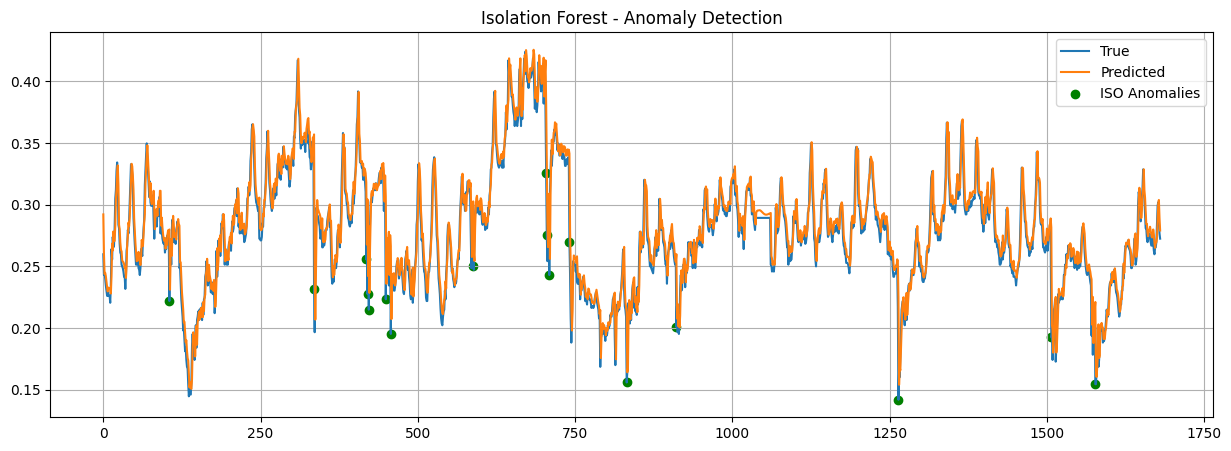

✅ Isolation Forest anomaly plot saved to: ../../outputs/LSTM_Model/isolation_forest_anomaly_plot.png
🌪️ ISO Anomaly at index 105 → True: 0.22, Predicted: 0.28, Residual: 0.06
🌪️ ISO Anomaly at index 335 → True: 0.23, Predicted: 0.36, Residual: 0.13
🌪️ ISO Anomaly at index 418 → True: 0.26, Predicted: 0.32, Residual: 0.06
🌪️ ISO Anomaly at index 420 → True: 0.23, Predicted: 0.30, Residual: 0.08
🌪️ ISO Anomaly at index 422 → True: 0.21, Predicted: 0.28, Residual: 0.07


In [103]:
# Isolation Forest anomaly detection

# convert preds_test and trues_test to 1D array with squeeze or flatten

if preds_test.ndim > 1:
    preds_test = preds_test.squeeze()
if trues_test.ndim > 1:
    trues_test = trues_test.squeeze()

residuals = np.abs(trues_test - preds_test)

iso_anomalies = isolation_forest_detection(residuals)

print(f"🌪️ Detected {len(iso_anomalies)} anomalies using Isolation Forest")

visualize_isolation_forest_anomalies(trues_test, preds_test, iso_anomalies)

# Close the TensorBoard writer

writer.close()

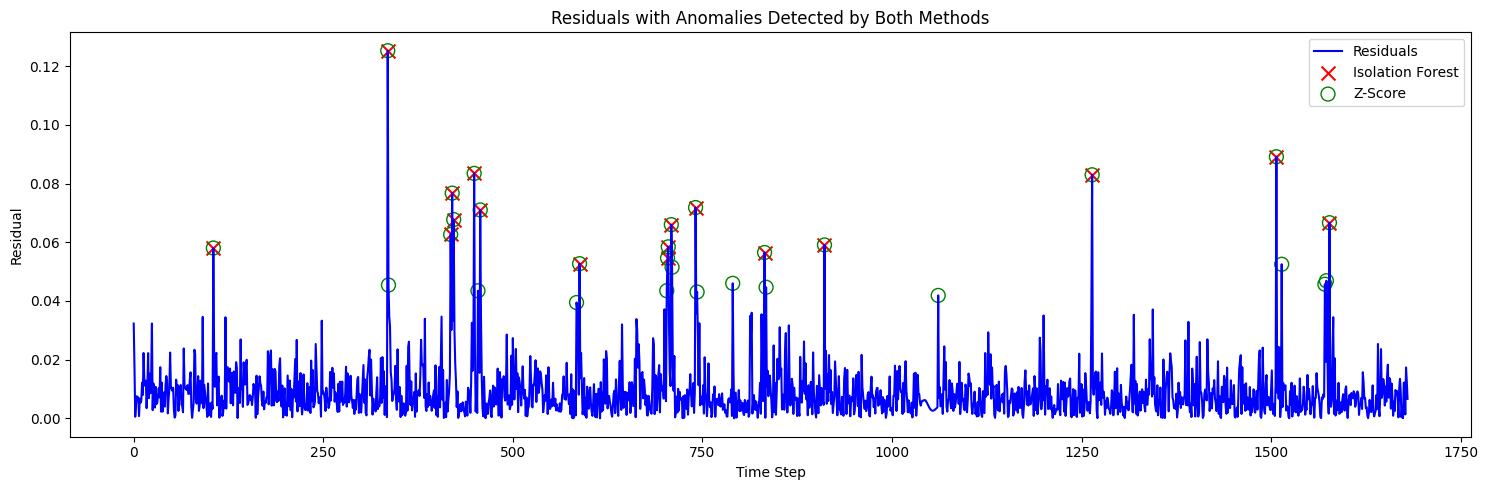

In [117]:
# Compare both anomaly detection methods (e.g., IForest & Z-Score) in one plot

# Ensure residuals is a NumPy array
residuals_np = residuals if isinstance(residuals, np.ndarray) else residuals.values
iso_anomalies_np = iso_anomalies if isinstance(iso_anomalies, np.ndarray) else iso_anomalies.values
zscore_anomalies_np = z_score_anomalies if isinstance(z_score_anomalies, np.ndarray) else z_score_anomalies.values

# Use np.arange for time steps
time_steps = np.arange(len(residuals_np))

plt.figure(figsize=(15, 5))
plt.plot(time_steps, residuals_np, label='Residuals', color='blue')

# Plot isolation forest anomalies
plt.scatter(time_steps[iso_anomalies_np], residuals_np[iso_anomalies_np],
            color='red', marker='x', label='Isolation Forest',s=100)

# Plot z-score anomalies
plt.scatter(time_steps[zscore_anomalies_np], residuals_np[zscore_anomalies_np],
            color='green', marker='o', label='Z-Score', facecolors='none',s=100)

plt.title("Residuals with Anomalies Detected by Both Methods")
plt.xlabel("Time Step")
plt.ylabel("Residual")
plt.legend()
plt.tight_layout()
plt.savefig("../../outputs/LSTM_Model/compare_anomaly_detection_methods.png")
plt.show()
